# Lab session 8 (Syntactic Parser) - IHLT

**Students:**
- Mario Rosas
- Alam Lopez

**Lab Professor:** Salvador Medina Herrera

## Paraphrases Template

In [37]:
%%shell
git clone https://github.com/mariorot/IHLT-MAI.git
cd 'IHLT-MAI'
mv 'complementary_material' /content/
mv scripts /content/
pip install svgling
pip install python-crfsuite

Cloning into 'IHLT-MAI'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 402 (delta 16), reused 12 (delta 12), pack-reused 381
Receiving objects: 100% (402/402), 325.83 KiB | 17.15 MiB/s, done.
Resolving deltas: 100% (239/239), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 17.7 MB/s eta 0:00:00


In [122]:
import nltk
from nltk import CFG, ChartParser, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser
import svgling
from scripts.text_preprocessing import TextPreprocessing
import string
import numpy as np

## TODO

- Consider the following sentence: **Lazy cats play with mice.**

- Expand the grammar of the example related to non-probabilistic chart parsers in order to subsume this new sentence.

- Perform the constituency parsing using a BottomUpChartParser, a BottomUpLeftCornerChartParser and a LeftCornerChartParser.

- For each one of them, provide the resulting tree, the number of edges and the list of explored edges.

- Which parser is the most efficient for parsing the sentence?

- Which edges are filtered out by each parser and why?

#### Failed attempt to generate grammar automatically

In [48]:
def sentence_to_cfg(sentence):
    words = TextPreprocessing().clean_sentence(sentence, signs=string.punctuation)
    pos_tags = nltk.pos_tag(words)

    productions = []

    for i in range(len(pos_tags)):
        productions.append(f"Word_{i} -> '{words[i]}'")
        productions.append(f"POS_{i} -> '{pos_tags[i][1]}'")

    for i in range(len(pos_tags) - 1):
        productions.append(f"Phrase_{i} -> Word_{i} | POS_{i}")
        productions.append(f"Sentence -> Phrase_{i} Phrase_{i+1}")

    cfg_string = "\n".join(productions)

    return CFG.fromstring(cfg_string)

# Example sentence
sentence = "The cat chased the mouse"

# Convert sentence to CFG
cfg = sentence_to_cfg(sentence)

# Print the CFG
print(cfg)

Grammar with 22 productions (start state = Word_0)
    Word_0 -> 'the'
    POS_0 -> 'DT'
    Word_1 -> 'cat'
    POS_1 -> 'NN'
    Word_2 -> 'chased'
    POS_2 -> 'VBD'
    Word_3 -> 'the'
    POS_3 -> 'DT'
    Word_4 -> 'mouse'
    POS_4 -> 'NN'
    Phrase_0 -> Word_0
    Phrase_0 -> POS_0
    Sentence -> Phrase_0 Phrase_1
    Phrase_1 -> Word_1
    Phrase_1 -> POS_1
    Sentence -> Phrase_1 Phrase_2
    Phrase_2 -> Word_2
    Phrase_2 -> POS_2
    Sentence -> Phrase_2 Phrase_3
    Phrase_3 -> Word_3
    Phrase_3 -> POS_3
    Sentence -> Phrase_3 Phrase_4


#### Introducing grammar manually

In [136]:
class sentence_to_cfg_parsing():
    def __init__(self, grammar):
      self.grammar = grammar
      self.pMethods = {'chart':ChartParser,
                       'bottomUp':BottomUpChartParser,
                       'bottomUpLeft':BottomUpLeftCornerChartParser,
                       'left': LeftCornerChartParser}

    def parse(self, sentence, method, rTree=0, verbose = False):
      print(f"---------- Using {method}")
      words = TextPreprocessing().clean_sentence(sentence, signs=string.punctuation)
      pos_tags = nltk.pos_tag(words)

      if verbose:
        print("\nPart of Speech of the sentence: ", pos_tags)

      parser = self.pMethods[method](self.grammar, trace=1)
      print('\n-- Char Parse')
      cparse = parser.chart_parse(words)
      print('\n-- Parse')
      parse = parser.parse(words)
      print(f'\n--Number of edges: {cparse.num_edges()}')
      print(f'\n-- Explored edges:\n {np.array(cparse.edges())}')
      trees = list(parse)
      print(f'\n--Number of trees:\n {len(trees)}')
      print("\n--Trees:")
      for i, tree in enumerate(trees):
        print(f'---Tree {i}: ', tree)

      if len(trees) != 0:
        print("\n")
        return trees[rTree]
      else:
        return "No Trees Found!"

In [137]:
grammar = CFG.fromstring('''
  NP  -> NNS | JJ NNS | NP CC NP
  NNS -> "cats" | "dogs" | "mice" | NNS CC NNS
  JJ  -> "big" | "small" | "lazy"
  CC  -> "and" | "or"
  VB -> "play"
  IN  -> "with"
  ''')

grammar2 = CFG.fromstring('''
  S   -> NP VB IN NP
  NP  -> NNS | JJ NNS | NP CC NP
  NNS -> "cats" | "dogs" | "mice" | NNS CC NNS
  JJ  -> "big" | "small" | "lazy"
  CC  -> "and" | "or"
  VB -> "play"
  IN  -> "with"
  ''')

s1="Lazy cats play with mice"
s2="Lazy cats and mice"
s3="small cats and mice"

##### Testing with grammar 1

In [138]:
CFGParse = sentence_to_cfg_parsing(grammar)

---------- Using chart

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] NP -> NP * CC NP
|.         .         [---------]         .| [2:3] CC -> 'and' 

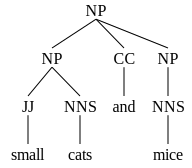

In [139]:
CFGParse.parse(s3, 'chart', 1, True)

---------- Using left

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] NP -> NP * CC NP
|.         .         [---------]         .| [2:3] CC -> 'and' *

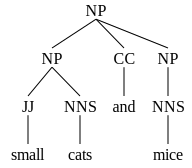

In [140]:
CFGParse.parse(s3, 'left', 1, True)

---------- Using bottomUp

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|>         .         .         .         .| [0:0] JJ -> * 'small'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|>         .         .         .         .| [0:0] NP -> * JJ NNS
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         >         .         .         .| [1:1] NNS -> * 'cats'
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         >         .         .         .| [1:1] NP -> * NNS
|.         >         .         .         .| [1:1] NNS -> * NNS CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NN

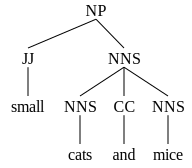

In [141]:
CFGParse.parse(s3, 'bottomUp', 1, True)

---------- Using bottomUpLeft

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] NP -> NP * CC NP
|.         .         [---------]         .| [2:3] CC ->

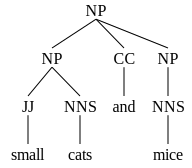

In [142]:
CFGParse.parse(s3, 'bottomUpLeft', 1, True)

##### Testing with grammar 2

In [143]:
CFGParse = sentence_to_cfg_parsing(grammar2)

In [144]:
CFGParse.parse(s3, 'chart', 0, True)

---------- Using chart

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] S  -> NP * VB IN NP
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] S  -> NP 

'No Trees Found!'

In [145]:
CFGParse.parse(s3, 'left', 0, True)

---------- Using left

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] NP -> NP * CC NP
|.         .         [---------]         .| [2:3] CC -> 'and' *

'No Trees Found!'

In [146]:
CFGParse.parse(s3, 'bottomUp', 0, True)

---------- Using bottomUp

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|>         .         .         .         .| [0:0] JJ -> * 'small'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|>         .         .         .         .| [0:0] NP -> * JJ NNS
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         >         .         .         .| [1:1] NNS -> * 'cats'
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         >         .         .         .| [1:1] NP -> * NNS
|.         >         .         .         .| [1:1] NNS -> * NNS CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NN

'No Trees Found!'

In [147]:
CFGParse.parse(s3, 'bottomUpLeft', 0, True)

---------- Using bottomUpLeft

Part of Speech of the sentence:  [('small', 'JJ'), ('cats', 'NNS'), ('and', 'CC'), ('mice', 'NN')]

-- Char Parse
|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] S  -> NP * VB IN NP
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] S 

'No Trees Found!'